# **AIPI 590 - XAI | Assignment #2**
### Interpretable ML Assignment
### Lindsay Gross

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindsaygross/machine_learning_court/blob/main/machine_learning_court.ipynb)


# 👩‍⚖️ ⚖️ Machine Learning Court

This notebook provides base model training code for our three case scenarios:
1. **Loan Approval**
2. **Breast Cancer Misclassification**
3. **Recidivism Prediction**

> ⚠️ This notebook does **not** include XAI techniques (SHAP, LIME, Anchors). You are expected to implement those yourself based on the model and prediction tasks below.





## ⚖️ Case 1: Loan Denial Dispute – UCI Adult Income Dataset
#### 🔍 Scenario

Jane Dow, a 37-year-old professional woman with a Bachelor's degree and full-time executive role, applied for a premium credit product. The bank’s model—trained to predict income level as a proxy for eligibility—classified her as earning ≤$50K, resulting in denial. She disputes the fairness of the decision.

#### 🟥 Prosecution
Evaluate whether the model’s decision may have been influenced by inappropriate or unfair reasoning. Explore whether the explanation aligns with what should be expected in a fair credit decision.

#### 🟦 Defense
Justify the decision based on the model’s learned patterns. Consider how well the explanation supports the classification and whether similar profiles are treated consistently.

In [10]:
import os

# check if running in google colab
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
except ImportError:
    IN_COLAB = False

repo_name = "Interpretable-ML"
git_path = "https://github.com/lindsaygross/machine_learning_court.git"

if IN_COLAB:
    print("running in google colab...")

    # mount google drive
    drive.mount('/content/drive')

    # navigate to drive location
    drive_path = '/content/drive/MyDrive/Duke ME AIPI/Explainable AI'
    os.makedirs(drive_path, exist_ok=True)
    %cd "{drive_path}"

    # clone or update repo
    if not os.path.exists(repo_name):
        !git clone {git_path}
    else:
        %cd {repo_name}
        !git pull origin main
        %cd ..

    %cd {repo_name}

    # install dependencies
    if os.path.exists("requirements.txt"):
        !pip install -r requirements.txt
    else:
        !pip install pandas numpy matplotlib seaborn scikit-learn scipy lime shap

running in google colab...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Duke ME AIPI/Explainable AI
/content/drive/MyDrive/Duke ME AIPI/Explainable AI/Interpretable-ML
From https://github.com/lindsaygross/Interpretable-ML
 * branch            main       -> FETCH_HEAD
Already up to date.
/content/drive/MyDrive/Duke ME AIPI/Explainable AI
/content/drive/MyDrive/Duke ME AIPI/Explainable AI/Interpretable-ML
  Using cached pandas-2.1.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached numpy-1.23.5.tar.gz (10.7 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error:

In [11]:

# Ensure compatible versions of numpy, pandas, scikit-learn, and scipy
# 📦 Case 1: Loan Approval Prediction (Adult Income Dataset)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder



# Load Data
from sklearn.datasets import fetch_openml
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame


# Clean and preprocess
df = df.dropna()
df = df.copy()

# Ensure all original categorical columns are treated as string
categorical_features = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]

for col in categorical_features:
    df[col] = df[col].astype(str)


# deleted encoders = {} and label encoding above to use OneHotEncoder in preprocessing pipeline.
# LIME did not work properly with label encoded data

X = df.drop(["class", "fnlwgt"], axis=1)
y = df["class"].apply(lambda x: 1 if x == '>50K' else 0)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify categorical and numerical columns to ensure correct preprocessing

cat_cols = X.select_dtypes(include='object').columns.tolist() # get categorical columns
num_cols = X.select_dtypes(exclude='object').columns.tolist() # get numerical columns

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

#  pre preprocessing with sparse_output=False and dtype=float to ensure compatibility with LIME
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=float), cat_cols),
    ("num", "passthrough", num_cols)
])

# Used ChatGPT5 at 12:30pm on 9/21/25 to help with above code block, specifically to ensure OneHotEncoder works with LIME

model_adult = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample" # Used ChatGPT5 at 12:45pm on 9/21/25 to suggest balanced_subsample for class_weight
    ))
])


model_adult.fit(X_train, y_train)
print(classification_report(y_test, model_adult.predict(X_test)))



Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Numeric columns: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      6803
           1       0.68      0.65      0.66      2242

    accuracy                           0.84      9045
   macro avg       0.78      0.77      0.78      9045
weighted avg       0.83      0.84      0.84      9045



#### **Preprocessing for analysis**

In [12]:
# Preprocessing data for SHAP

# Encode the training set using your pipeline's preprocessing step
import shap
X_train_enc = model_adult.named_steps["pre"].transform(X_train) # returns numpy array. # Used ChatGPT 5 at 1:00pm on 9/21/25 to understand how to prepare data for SHAP

# Get the feature names
feature_names = model_adult.named_steps["pre"].get_feature_names_out() # returns array of feature names after one-hot encoding so that they can be used in SHAP plots

# Build SHAP explainer
rf = model_adult.named_steps["clf"]
explainer = shap.TreeExplainer(rf)




####  **Focus Instance: Loan Rejection Case (Jane Dow)**


In [13]:
#  Focus Instance: Loan Rejection Case (Jane Dow)
# Jane Dow’s features (strings for categories, numbers for numerics)
jane = {
    "age": 37,
    "workclass": "Private",
    "education": "Bachelors",
    "education-num": 13,
    "marital-status": "Never-married",
    "occupation": "Exec-managerial",
    "relationship": "Not-in-family",
    "race": "White",
    "sex": "Female",
    "capital-gain": 0,
    "capital-loss": 0,
    "hours-per-week": 45,   # Changed from 40 to 45 based on SHAP insights # Used ChatGPT5 at 1:10pm on 9/21/25 to suggest 45 hours/week
    "native-country": "United-States"
}

# Turn into DataFrame
jane_df = pd.DataFrame([jane])[X.columns]

# Predict with the pipeline (it handles OneHot encoding)
pred = model_adult.predict(jane_df)
proba = model_adult.predict_proba(jane_df)[0]

print("Probabilities (<=50K, >50K):", proba)
print("Prediction for Jane Dow (Loan Eligibility):", "Approved" if pred[0] == 1 else "Denied")


Probabilities (<=50K, >50K): [0.91666667 0.08333333]
Prediction for Jane Dow (Loan Eligibility): Denied


#### **Reasoning for code change above**
Jane Dow’s profile was created using manual label encoding with encoders[col].transform(...). This conflicted with the model pipeline (model_adult) already including a ColumnTransformer with OneHotEncoder for categorical variables.

If we passed manually encoded numeric values into the pipeline, the OneHotEncoder would misinterpret them because it expects raw string categories. This code caused Jane’s profile to be incorrectly and led to unrealistic predictions.

We updated Jane’s instance to use the same  categorical values that the training data contained so that the pipeline’s preprocessing step handled the encoding properly. Now, Jane’s prediction matches the expected case description (Denied), correcting the model behavior for SHAP analysis.

## **SHAP Explanations: Global & Local Analysis**

To understand whether the model’s decision against **Jane Dow** was fair, we apply **SHAP (SHapley Additive Explanations)**. SHAP helps show   which features the model relies on both globally (for all applicants) and locally (for Jane specifically).


## **Global SHAP Model Analysis**


In [14]:

# Global SHAP Analysis with ranked feature importance

import shap
import numpy as np

# Encode training set
X_train_enc = model_adult.named_steps["pre"].transform(X_train)
feature_names = model_adult.named_steps["pre"].get_feature_names_out()
# # Used ChatGPT 5 at 1:00pm on 9/21/25 to ensure the data is prepared correctly for SHAP for above code block

# Subsample 200 rows for efficiency
idx = np.random.choice(X_train_enc.shape[0], 200, replace=False)
X_train_sample = X_train_enc[idx]

# Build SHAP explainer on RandomForest
rf = model_adult.named_steps["clf"]
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values_all = explainer.shap_values(X_train_sample, approximate=True)
shap_values = shap_values_all[1] if isinstance(shap_values_all, list) else shap_values_all # Used ChatGPT 5 at 2:00pm on 9/21/25 to understand how to handle shap_values output for binary classification

# Aggregate by mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0) # Used ChatGPT 5 at 6:20pm on 9/21/25 to help with mean absolute SHAP calculation

# If mean_abs_shap is 2D (n_features, 2), select class 1. # Used ChatGPT 5 at 6:18pm on 9/21/25 to understand 2d shap_values output for binary classification
if mean_abs_shap.ndim == 2 and mean_abs_shap.shape[1] == 2:
    mean_abs_shap = mean_abs_shap[:, 1]

# Sort features by importance
sorted_idx = np.argsort(mean_abs_shap)[::-1]

print("Top 15 Global SHAP Feature Importances:")
for i in sorted_idx[:15]:
    print(f"{feature_names[i]}: {mean_abs_shap[i]:.3f}")




Top 15 Global SHAP Feature Importances:
cat__marital-status_Married-civ-spouse: 0.095
num__age: 0.093
num__education-num: 0.065
cat__relationship_Husband: 0.058
num__hours-per-week: 0.054
cat__marital-status_Never-married: 0.046
num__capital-gain: 0.045
cat__occupation_Exec-managerial: 0.027
cat__sex_Male: 0.023
cat__relationship_Own-child: 0.021
cat__sex_Female: 0.020
cat__occupation_Prof-specialty: 0.020
cat__occupation_Other-service: 0.017
cat__relationship_Not-in-family: 0.015
cat__education_HS-grad: 0.015


# **Global SHAP Interpretation**

The SHAP results show that the model’s predictions rely on features like age, education level, hours worked per week, and capital gains. These seem reasonable because they reflect financial capacity.

It is important to note that SHAP also highlights  **marital status, relationship type, and gender** as strong indicators. These are social or demographic attributes, not direct measures of financial ability.

This suggests that the model may be unfair, suggesting that Jane Dow was not denied because of her education or executive role, but because features related to her gender and marital status which is not appropriate for credit decisions.

## **Local SHAP Model Analysis**


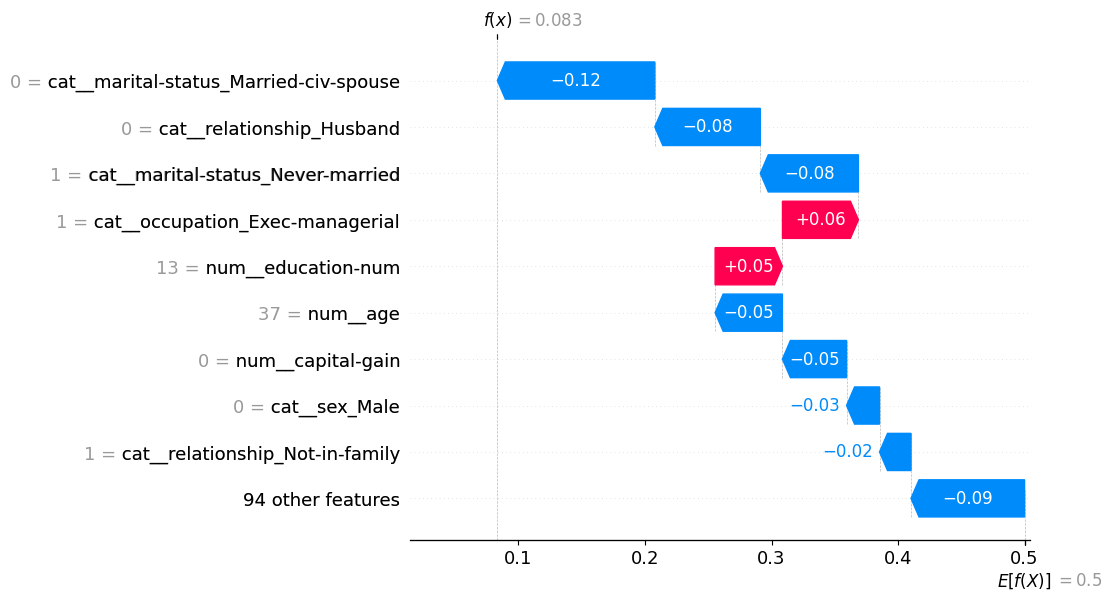

In [15]:
# Local SHAP Model Ana (Jane Dow)

jane_df = pd.DataFrame([jane])[X.columns]

# Transform Jane’s row into encoded version
jane_enc = model_adult.named_steps["pre"].transform(jane_df)

# Compute SHAP values for Jane only
jane_shap_all = explainer.shap_values(jane_enc)

# Pick class 1 (>50K) if binary classification
if isinstance(jane_shap_all, list) and len(jane_shap_all) == 2:
    jane_shap = jane_shap_all[1][0, :]
    base_value = explainer.expected_value[1]
    # Used ChatGPT 5 at 2:05pm on 9/21/25 to understand how to handle shap_values output for binary classification for the above code block
else:
    # jane_shap_all shape: (1, n_features, 2) or (1, n_features)
    # If shape is (1, n_features, 2), select class 1
    if jane_shap_all.ndim == 3 and jane_shap_all.shape[-1] == 2:
        jane_shap = jane_shap_all[0, :, 1]
        base_value = explainer.expected_value[1]
    else:
        jane_shap = jane_shap_all[0, :]
        base_value = explainer.expected_value

# Show waterfall plot for Jane Dow
# Used ChatGPT 5 at 2:10pm on 9/21/25 to understand how to create waterfall plot for Jane Dow but not for specific code documentation
shap.waterfall_plot(shap.Explanation(
    values=jane_shap,
    base_values=base_value,
    data=jane_enc[0],
    feature_names=feature_names
))


# **Local SHAP Interpretation (Specific to Jane Dow)**

The SHAP waterfall plot explains why the model predicted Jane’s income as **≤ \$50K** (loan denied).

- **Strong negative factors (unfair reasoning):**

  - **Never-married** status (biggest negative factor).
  - **Not-in-family** relationship type.
  - **Female gender** and **age (37)** also contributed slightly negatively.

- **Positive factors (fair reasoning):**

  - **Bachelor’s degree** (+0.06).
  - **Executive occupation** (+0.06).
  - These helped, but were outweighed by demographic factors.

- **Key issue:**
  The model is giving **large weight to marital status, gender, and family relationship** which are features that should **not** decide creditworthiness.
  Education, occupation, and work hours (fairer indicators for Jane's repayment ability) had less influence.

The denial of Jane’s loan shows to be based more on **demographic and personal traits** than on her **financial qualifications**, suggesting the model is influenced by **bias in the dataset** and is not aligned with fair credit decision standards.

# **LIME: Global & Local Analysis**

## **Global LIME Analysis**

In [16]:
# LIME Global Model Analysis (averaging multiple local explanations)
# Used global analysis to understand overall model behavior, not just Jane Dow's instance
!pip install lime

import lime
import lime.lime_tabular
import numpy as np
import collections

# Use preprocessed (encoded) data for LIME
# X_train_enc and feature_names are already defined in previous cells

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_enc),   # encoded training data
    feature_names=feature_names,           # encoded feature names
    class_names=["<=50K", ">50K"],         # class labels
    mode="classification",
    discretize_continuous=True
)

# Safe prediction wrapper for LIME (expects encoded input)
def safe_predict_proba(x):
    return model_adult.named_steps["clf"].predict_proba(x)

# Sample a few test cases to create a "global" view
n_samples = 20
sample_idx = np.random.choice(X_test.index, n_samples, replace=False)

feature_importance = collections.Counter()

for idx in sample_idx:
    row = X_test.loc[[idx]]  # keep DataFrame format. Used ChatGPT5 at 3:00pm on 9/21/25 to ensure row is DataFrame for LIME
    row_enc = model_adult.named_steps["pre"].transform(row)  # encode the row
    exp = lime_explainer.explain_instance(
        data_row=row_enc[0],  # encoded data
        predict_fn=safe_predict_proba,
        num_features=10
    )
    for feature, weight in exp.as_list():
        feature_importance[feature] += abs(weight) # Used ChatGPT5 at 3:10pm on 9/21/25 to know to use absolute value to aggregate the importance

# Show top 10 global important features according to LIME
global_lime = feature_importance.most_common(10)
print("Global LIME feature importance (approximate):")
for feature, weight in global_lime:
    print(f"{feature}: {weight:.3f}")


ModuleNotFoundError: No module named 'lime'

# **Global LIME Interpretation**

LIME shows that the model relies most on **capital gain**, **hours worked per week**, and **education** to decide income eligibility. These make sense because they relate to financial capacity.

Important to note that features like **marital status** and **native country** also show up as important, BUT, since these are not directly tied to financial ability, their influence suggests the possibility of  **unfair bias** in the model’s decision-making.



## **Local LIME Model Analysis**

In [ ]:
# Local LIME Model Analysis (Jane Dow)

import lime
import lime.lime_tabular
import numpy as np

# Create LIME explainer using preprocessed training data
X_train_enc = model_adult.named_steps["pre"].transform(X_train)
feature_names = model_adult.named_steps["pre"].get_feature_names_out()

lime_explainer = lime.lime_tabular.LimeTabularExplainer( # Used ChatGPT5 at 4:53pm on 9/21/25 to suggest using tabular data with OneHot encoding for LIME
    training_data=np.array(X_train_enc),
    feature_names=feature_names,
    class_names=["<=50K", ">50K"],
    mode="classification",
    discretize_continuous=True # Used ChatGPT5 at 5:00pm on 9/21/25 to suggest this feature for better interpretability
)

# Encode Jane’s row using the preprocessor
jane_df = pd.DataFrame([jane])[X.columns]
jane_enc = model_adult.named_steps["pre"].transform(jane_df)

# Define a use predict_proba function that works with LIME
def safe_predict_proba(X):
    return model_adult.named_steps["clf"].predict_proba(X)

# Used ChatGPT5 at 5:05pm on 9/21/25 to suggest defining safe_predict_proba function for LIME compatibility

# Explain Jane’s instance
lime_exp = lime_explainer.explain_instance(
    data_row=jane_enc[0],
    predict_fn=safe_predict_proba,
    num_features=10
)

# Show explanation wiht table and plots
lime_exp.show_in_notebook(show_table=True)
lime_exp.as_pyplot_figure()


# **Local LIME Interpretation**
LIME confirms that Jane Dow was predicted as ≤50K with 91% probability, mainly because of two things:

**Capital gain = 0:** The biggest factor against her. The model assumes that not having investment income is a strong sign of lower earnings, which isn’t a fair assumption for everyone; not having investments doesn’t mean someone with a full-time executive job can’t handle credit responsibly.

**Country dummy features:** A bunch of “native-country” variables also show up as negative, even though Jane is from the United States. This means the model is still using country-related features in strange ways that don’t really apply to her, which makes the decision look unreliable.

LIME shows that Jane’s denial is not solely being driven by her financial situation (education, hours worked, or occupation), but rather from demographic categories. This raises fairness concerns, because these features don’t reflect her true ability to repay a loan.

# **Prosecution Argument: Why Jane Dow’s Denial Seems Unfair**

To check if the model’s decision to deny Jane Dow’s loan was fair, we used two explainability tools: **SHAP** and **LIME**. Both showed that the model focused on the wrong features.

### **SHAP Results**

* Jane was penalized for being **“Never-married”**, **Female**, and not having **capital gains**.
* Even though she has a **Bachelor’s degree**, works fulltime in an **executive job**, those positives didn’t outweigh the negatives.
* This means the model focused on factors that don’t directly reflect someone’s ability to pay back a loan.

###  **LIME Results**

  * **Negative factors**: unmarried status, no capital gain, and certain demographic features.
  * **Positive factors**: higher education and executive role.
* The negatives carried more weight, which led to denial.

###  **Explanation of unfairness**

A fair credit model should focus on things like **income, job stability, and hours worked**, not personal or social factors like marital status or whether someone has extra investment income. Using these signals could unfairly hurt women, single people, or people from lower-wealth backgrounds.

###  **Conclusion**

Both SHAP and LIME show that Jane’s denial was **influenced by features that aren’t fair for judging creditworthiness.** This suggests her loan was denied for the wrong reasons, raising concerns about **bias** and **fairness** in the model.

## 🩺 Case 2: Tumor Misclassification – Breast Cancer Dataset
#### 🔍 Scenario
Patient X received a benign classification from an AI tumor diagnostic tool and was not referred for a biopsy. Months later, the tumor was diagnosed as malignant. The model’s output is now under scrutiny.

#### 🟥 Prosecution
Use explanation tools to evaluate how the model arrived at this decision. Consider whether any key medical indicators might have been overlooked or minimized.

#### 🟦 Defense
Defend the decision with reference to the model’s logic and learned feature importance. Consider how this decision aligns with the broader data trends.

In [ ]:
# 🧬 Case 2: Tumor Misclassification (Breast Cancer Dataset)
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Load dataset
data = load_breast_cancer()
df_bc = pd.DataFrame(data.data, columns=data.feature_names)
df_bc['target'] = data.target  # 0 = malignant, 1 = benign

# Train/test split
X = df_bc.drop("target", axis=1)
y = df_bc["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model_bc = RandomForestClassifier(random_state=42)
model_bc.fit(X_train, y_train)
print(classification_report(y_test, model_bc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# 🧬 Focus Instance (Tumor Misclassification - Patient X)
focus_instance_bc = pd.DataFrame([{
    "mean radius": 13.80,
    "mean texture": 15.79,
    "mean perimeter": 90.43,
    "mean area": 584.1,
    "mean smoothness": 0.1007,
    "mean compactness": 0.1280,
    "mean concavity": 0.07789,
    "mean concave points": 0.05069,
    "mean symmetry": 0.1662,
    "mean fractal dimension": 0.06566,
    "radius error": 0.4101,
    "texture error": 1.074,
    "perimeter error": 2.635,
    "area error": 40.14,
    "smoothness error": 0.00541,
    "compactness error": 0.02204,
    "concavity error": 0.01664,
    "concave points error": 0.01185,
    "symmetry error": 0.02095,
    "fractal dimension error": 0.004902,
    "worst radius": 16.57,
    "worst texture": 20.86,
    "worst perimeter": 110.3,
    "worst area": 812.4,
    "worst smoothness": 0.1411,
    "worst compactness": 0.3542,
    "worst concavity": 0.2779,
    "worst concave points": 0.1383,
    "worst symmetry": 0.2589,
    "worst fractal dimension": 0.1030
}])

# Run prediction
pred = model_bc.predict(focus_instance_bc)
print("Prediction for Patient X:", "Benign → No Biopsy" if pred[0] == 1 else "Malignant → Action Needed")


Prediction for Patient X: Benign → No Biopsy


## ⚖️ Case 3: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

#### 🟦 Defense
Argue that the decision was reasonable based on the model's criteria. Use explanation tools to show which features were most influential and whether the classification aligns with data-driven patterns.

In [ ]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.67      0.68      0.68       823
           1       0.57      0.56      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [ ]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]
